In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pickle

# **CAMERA CALIBRATION**

camera_cal\calibration1.jpg: corners not found
camera_cal\calibration4.jpg: corners not found
camera_cal\calibration5.jpg: corners not found


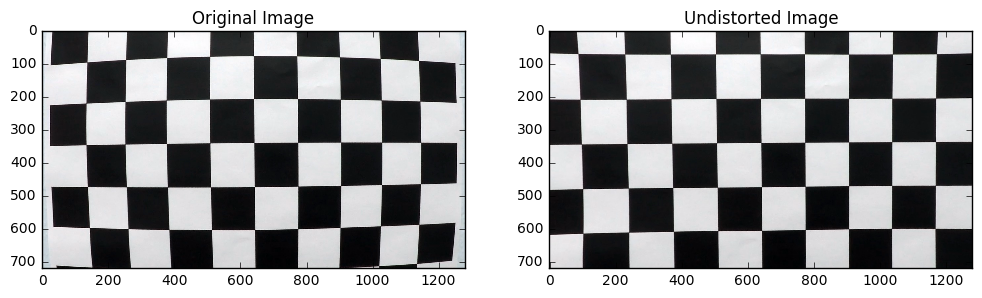

In [36]:
# GET UNDISTORTION MATRIX OF CAMERA
imgFolder = 'camera_cal'
image_list = glob.glob('%s/*.jpg' % imgFolder)
chessX = 9
chessY = 6
objPoints = []
imgPoints = []
cornerImgs = []
for imagePath in image_list:
    objp = np.zeros((chessY*chessX,3), np.float32)
    # numpy magic from Advanced Lane Finding unit 10 to distribute x and y values
    objp[:,:2] = np.mgrid[0:chessX, 0:chessY].T.reshape(-1,2)

    img = cv2.imread(imagePath)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # mpimg.imread returns RGB image
    ret, corners = cv2.findChessboardCorners(gray, (chessX,chessY),None)
    if ret == True:
        imgPoints.append(corners)
        objPoints.append(objp)
        cornerImgs.append(cv2.drawChessboardCorners(img, (chessX,chessY), corners, ret))
    else:
        print('%s: corners not found' % imagePath)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1],None,None)

# write out calibration data
with open('cameraCalibration.pickle', 'wb') as fp:
    pickle.dump([mtx, dist, rvecs, tvecs], fp)

# Plot an example
fig = plt.figure(figsize=(12, 7))
a=fig.add_subplot(1,2,1)
img = cv2.imread(image_list[0])
imgplot = plt.imshow(img)
a.set_title('Original Image')
a=fig.add_subplot(1,2,2)
dst = cv2.undistort(img, mtx, dist, None, mtx)
imgplot = plt.imshow(dst)
a.set_title('Undistorted Image')
plt.show()

In [23]:
# write camera calibration images
i = 1
outFolder = 'camera_cal_outImgs/cornerImgs'

for img in cornerImgs:
    outFile = '%s/calibration_corners%s.jpg' % (outFolder, i)
    cv2.imwrite(outFile, img)
    i+=1

# write undistorted checkerboard images
outFolder = 'camera_cal_outImgs'
for imagePath in image_list:
    img = cv2.imread(imagePath)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    imgNumber = imagePath.split('calibration')[1].split('.jpg')[0]
    outFile = '%s/calibration%s_undistort.jpg' % (outFolder, imgNumber)
    cv2.imwrite(outFile, dst)

**NOTES**

Three images did not show the entire checkerboard and resulted in cv2.findChessboardCorners() to fail. My first preference was to still make use of the data points and try to run the corner detection with different x and y values. This still didn't yield satisfactory results. First, it was an awkward iterative search for parameters that yielded a sucessful edge detection AND correctly detected corners. Secondly, I would still get an errand corner detected at coordinate 0,0. Upon reading up on findChessboardCorners(), it appears to be very "finicky" and expects a clean white edge around the checkerboard. Instead of fixing the images in Photoshop and trying to force a clean detection, I decided to simply ignore the three images. There is still plenty of data for a good camera calibration.
___

# PIPELINE

In [4]:
warpedImgSize = (800, 1000)
#warpedImgSize = (img.shape[1], img.shape[0])
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/warpedImgSize[1] # meters per pixel in y dimension
xm_per_pix = 5/warpedImgSize[0] # meters per pixel in x dimension

slidingWindow_margin = int(warpedImgSize[0]/12.8)
slidingWindow_windows = 9
marginSearch_margin = int(warpedImgSize[0]/12.8)

# Visualize
fontFace = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.7
thickness = 2

In [5]:
# UTILITY FUNCTIONS

# Create thresholded binary image
def makeGrayImg(img, mask=None, colorspace='rgb', useChannel=0):
    '''
    Returns a grey image based on the following inputs
    - mask
    - choice of color space
    - choice of channel(s) to use
    '''
    # color space conversion
    if colorspace == 'gray':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    elif colorspace == 'hsv':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif colorspace == 'hls':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif colorspace == 'lab':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    elif colorspace == 'luv':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif colorspace == 'yuv':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # isolate channel
    if colorspace != 'gray':
        img = img[:,:,useChannel]

    # apply image mask
    if mask is not None:
        imgMask = np.zeros_like(img)    
        ignore_mask_color = 255
        # filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(imgMask, mask, ignore_mask_color)
        # returning the image only where mask pixels are nonzero
        img = cv2.bitwise_and(img, imgMask)
    return img
                
def makeBinaryImg(img, threshold=(0,255), mode='simple', sobel_kernel=3):
    '''
    Returns a binary image based on the following inputs
    - threshold
    - threshold mode
    -- 'dir' requires a non-8 bit threshold
    '''
    binary = np.zeros_like(img)
    if mode == 'sobelX':
        sobelX_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        scaled_sobelX = np.uint8(255*sobelX_abs/np.max(sobelX_abs))
        binary[(scaled_sobelX >= threshold[0]) & (scaled_sobelX <= threshold[1])] = 1
    elif mode == 'sobelY':
        sobelY_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        scaled_sobelY = np.uint8(255*sobelY_abs/np.max(sobelY_abs))
        binary[(scaled_sobelY >= threshold[0]) & (scaled_sobelY <= threshold[1])] = 1
    elif mode == 'mag':
        sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # calculate the magnitude
        sobel_mag = np.sqrt(np.square(sobelX) + np.square(sobelY))
        # scale to 8-bit (0 - 255) and convert to type = np.uint8
        sobel_scale = np.uint8(255*sobel_mag/np.max(sobel_mag))
        # create a binary mask where mag thresholds are met
        binary[(sobel_scale >= threshold[0]) & (sobel_scale <= threshold[1])] = 1
    elif mode == 'dir':
        sobelX_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        scaled_sobelX = np.uint8(255*sobelX_abs/np.max(sobelX_abs))
        sobelY_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        scaled_sobelY = np.uint8(255*sobelY_abs/np.max(sobelY_abs))
        # use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        gradients = np.arctan2(scaled_sobelY, scaled_sobelX)
        binary[(gradients >= threshold[0]) & (gradients <= threshold[1])] = 1
    else:
        binary[(img >= threshold[0]) & (img <= threshold[1])] = 1  
    return binary


def writeImg(img, outFile, binary=False):
    if binary:
        # scale to 8-bit (0 - 255)
        img = np.uint8(255*img)
    cv2.imwrite(outFile, img)
    

def findLaneBases(binary_warped):
    '''
    input: binary warped img
    returns: x coordinates of estimated left/right lane bases
    from: Udacity Project 4 lesson, unit 33
    '''
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

def slidingWindowFit(binary_warped, x_base, nwindows=9, margin=100, minpix=50, lanePxColor=(0,0,220)):
    '''
    input: binary warped img
           nwindows: number of sliding windows
           margin: width of the windows +/- margin
           minpix: minimum number of pixels found to recenter window
    returns: return status (True/False), polyFit function for lane, image with visualizations
    based on: Udacity Project 4 lesson, unit 33
    '''
    nWindowsForSuccess = np.floor(nwindows/3)
    filterPrevWindowThres = 10 # make threshold large to disable filtering
    
    # Visualize
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 2
    visCircleRad = 5
    # Create an output image to draw on and  visualize the result
    size = binary_warped.shape[0], binary_warped.shape[1], 3
    data_img = np.zeros(size, dtype=np.uint8)
    # draw lane base
    cv2.circle(data_img, (x_base,720), visCircleRad, (255,0,0), thickness=-1)
    #cv2.circle(data_img, (rightx_base,720), visCircleRad, (255,0,0), thickness=-1)
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    x_current = x_base
    # Create empty lists to receive left and right lane pixel indices
    lane_inds = []
    
    # Step through the windows one by one
    x_prev = 0
    x_prevChange = 0
    valid_window_count = 0
    for window in range(nwindows):
        '''
        keep track of previous search window position/rate of change in the curve to prevent outliers
        '''
        valid_window = False
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_y = int(win_y_low+(window_height/2))
        win_x_low = x_current - margin
        win_x_high = x_current + margin
        # Identify the nonzero pixels in x and y within the window
        # take .nonzero()[0] since all we really need is a simple count. Don't care where they actually are
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_inds) > minpix:
            x_current = np.int(np.mean(nonzerox[good_inds]))            
            x_currentChange = x_current - x_prev
            # FILTER: If sign flips and value change is above threshold, ignore window (if sign doesn't flip or change is below threshold)
            # But have to ignore influence of first window (very large change in x)
            if ((x_prevChange<0)==(x_currentChange<0)) or ((x_prevChange-x_currentChange) < filterPrevWindowThres) or window==1:
                # Append indices to the lists
                lane_inds.append(good_inds)
                valid_window = True
                valid_window_count += 1
            else:
                # if it turns out bad, reset location and keep moving ROI for next window in the previous direction
                x_current = x_prev+x_prevChange                
        else:
            x_currentChange = 0
            
        # Draw the windows on the visualization image
        visCircleRad = 5
        if valid_window:
            color = (0,255,0)
            # Color in line pixels
            data_img[nonzeroy[good_inds], nonzerox[good_inds]] = lanePxColor
        else:
            color = (100,100,100)
        cv2.rectangle(data_img,(win_x_low,win_y_low),(win_x_high,win_y_high),color, 2)
        cv2.circle(data_img, (x_current, win_y), visCircleRad, color, thickness=-1)
        cv2.putText(data_img, '%s'%x_currentChange, (x_current-70, win_y), fontFace, fontScale,color, thickness)
        x_prev = x_current
        x_prevChange = x_currentChange
        
    # check if enough good points were detected for lane to be valid
    if valid_window_count < nWindowsForSuccess:
        return False, None, data_img

    # Concatenate the arrays of indices
    lane_inds = np.concatenate(lane_inds)

    # Extract left and right line pixel positions
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds] 
 
    # Fit a second order polynomial to each
    fit = np.polyfit(y, x, 2)
    fit_f = np.poly1d(fit)
    return True, fit_f, data_img

def marginSearch(binary_warped, fit_f, margin=100, minpix=50, lanePxColor=(0,0,220), laneColor=(0,150,0)):
    # Assume you now have a new warped binary image from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    lane_inds = ((nonzerox > (fit_f(nonzeroy) - margin)) & (nonzerox < (fit_f(nonzeroy) + margin))) 
    # Again, extract line pixel positions
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds] 
    # Fit a second order polynomial to each
    fit = np.polyfit(y, x, 2)
    fit_f = np.poly1d(fit)
    # Visualize
    # Create an output image to draw on and  visualize the result
    size = binary_warped.shape[0], binary_warped.shape[1], 3
    data_img = np.zeros(size, dtype=np.uint8)
    # Generate x and y values for plotting
    fity = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    fit_x = fit_f(fity)
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    line_window1 = np.array([np.transpose(np.vstack([fit_x-margin, fity]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_x+margin, fity])))])
    line_pts = np.hstack((line_window1, line_window2))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(data_img, np.int_([line_pts]), laneColor)    
    # Color in line pixels
    data_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = lanePxColor
    return True, fit_f, data_img

def getCurveRadius(fit_f):
    '''
    input: curve fit function  
    returns: radius of curvature in meters
    based on: Udacity Project 4 lesson, unit 34
    '''   
    ploty = np.linspace(0, warpedImgSize[1]-1, warpedImgSize[1])
    # Define y-value where we want radius of curvature. Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    x = fit_f(ploty)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, x*xm_per_pix, 2)   
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    # Now our radius of curvature is in meters
    return curverad

def getCarPositionOffCenter(fit_f_left, fit_f_right):
    '''
    inputs: function for left and right lanes
    returns: car position off center in meters
    '''
    base_left = fit_f_left(warpedImgSize[1])
    base_right = fit_f_right(warpedImgSize[1])
    centerOfLanes = base_left+((base_right-base_left)/2)
    offset = (centerOfLanes-(warpedImgSize[0]/2))*xm_per_pix
    return offset

def makeFinalImage(img, fit_f_left, fit_f_right, Minv, curvature, offCenter, laneColor=(0,255,0)):
    '''
    inputs: original undistorted image
            function for left and right lanes
            inverse perspective transform matrix
            curve radius
            position of car off-center
    output: final image
    '''
    size = warpedImgSize[1], warpedImgSize[0], 3
    data_img = np.zeros(size, dtype=np.uint8)
    ploty = np.linspace(0, warpedImgSize[1]-1, warpedImgSize[1])
    fit_xLeft = fit_f_left(ploty)
    fit_xRight = fit_f_right(ploty)
    line_window1 = np.array([np.transpose(np.vstack([fit_xLeft, ploty]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([fit_xRight, ploty])))])
    line_pts = np.hstack((line_window1, line_window2))
    cv2.fillPoly(data_img, np.int_([line_pts]), laneColor)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    data_img = cv2.warpPerspective(data_img, Minv, (img.shape[1], img.shape[0]))
    
    img = cv2.addWeighted(img, 1., data_img, 1., 0.)
    cv2.putText(img, 'curve radius: {:.0f}m'.format(curvature), (600, 20), fontFace, fontScale,(0,255,0), thickness)
    cv2.putText(img, 'off center: {:.1f}m'.format(offCenter), (600, 100), fontFace, fontScale,(0,255,0), thickness)
    return img

## TEST IMAGE PROCESSING

In [6]:


# load camera calibration data
with open('cameraCalibration.pickle', 'rb') as fp:
    mtx, dist, rvecs, tvecs = pickle.load(fp)

imgFolder = 'test_images'
image_list = glob.glob('%s/*.jpg' % imgFolder)
dstImgs = []
binImgs = []
perspTransImgs = []

i=0

for imagePath in image_list:
    imgNumber = image_list[i].split('.jpg')[0].split('\\')[1][-1]
    imgName = image_list[i].split('.jpg')[0].split('\\')[1][:-1]
    outFileTemplate = '%s%s' % (imgName, imgNumber)
    
    img = cv2.imread(imagePath)
    img_size = (img.shape[1], img.shape[0])
    # Undistort
    dstImg = cv2.undistort(img, mtx, dist, None, mtx)
    dstImgs.append(dstImg)
    
    # get useful greyscale channels
    hls_s = makeGrayImg(dstImg, colorspace='hls', useChannel=2)
    hsv_v = makeGrayImg(dstImg, colorspace='hsv', useChannel=2)
    hls_l = makeGrayImg(dstImg, colorspace='hls', useChannel=1)
    
    # histogram equalization test
    hsv_v_equi = cv2.equalizeHist(hsv_v)
    
    # create binary image    
    #imgNumber = imagePath.split('.jpg')[0].split('\\')[1][-1]
    #imgName = imagePath.split('.jpg')[0].split('\\')[1][:-1]
    
    # good general result, deals well with low contrast
    bin_hls_s_thresh = makeBinaryImg(hls_s, threshold=(150,255), mode='simple')
    # generally better result than hls_s_thresh
    # deals VERY poorly with low contrast road surface, but deals GREAT with shadows
    bin_hsv_v_thresh = makeBinaryImg(hsv_v_equi, threshold=(210,255), mode='simple')
    # better in all aspects than sobelX or dir. Using non-equalized hsv_v because it has more contrast
    bin_hsv_v_mag_equi = makeBinaryImg(hsv_v_equi, threshold=(90,255), mode='mag')
    # simple sobelX to fill in
    bin_hsv_v_sobelX = makeBinaryImg(hsv_v, threshold=(20,100), mode='sobelX')
    
    # two different binary images. binLowContrast can deal with low contrast better while binHighContrast is much less noisy
    binHighContrast = np.zeros_like(hls_s)
    binHighContrast[(bin_hls_s_thresh == 1) | (bin_hsv_v_mag_equi == 1)] = 1 
    binLowContrast = np.zeros_like(hls_s)
    binLowContrast[(bin_hls_s_thresh == 1) | (bin_hsv_v_sobelX == 1)] = 1
    binShadowSpec = np.zeros_like(hls_s)
    binShadowSpec[(bin_hsv_v_mag_equi == 1) | (bin_hsv_v_thresh == 1)] = 1
    
    # Perspective transform
    src = np.float32(
        [[30, 670],
         [1250, 670],
         [710, 448],
         [570, 448]])
    dst = np.float32(
        [[0, warpedImgSize[1]],
         [warpedImgSize[0], warpedImgSize[1]],
         [warpedImgSize[0], 0],
         [0, 0]])
    
    outFolder = 'test_images_outImgs/perspTrans'
    
    srcArr = np.array( [src], dtype=np.int32 )
    roiOverlay = np.copy(dstImg)
    roiOverlay = cv2.fillPoly(roiOverlay, srcArr, 255)
    #outFile = '%s/%s%s_roi.jpg' % (outFolder, imgName, imgNumber)
    #writeImg(roiOverlay, outFile)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warpedHC = cv2.warpPerspective(binHighContrast, M, warpedImgSize, flags=cv2.INTER_LINEAR)
    #outFile = '%s/%s%s_warpedHC.jpg' % (outFolder, imgName, imgNumber)
    #writeImg(warpedHC, outFile, binary=True)
    warpedLC = cv2.warpPerspective(binLowContrast, M, warpedImgSize, flags=cv2.INTER_LINEAR)
    #outFile = '%s/%s%s_warpedLC.jpg' % (outFolder, imgName, imgNumber)
    #writeImg(warpedLC, outFile, binary=True)
    warpedOrig = cv2.warpPerspective(dstImg, M, warpedImgSize, flags=cv2.INTER_LINEAR)
    #outFile = '%s/%s%s_warpedOrig.jpg' % (outFolder, imgName, imgNumber)
    #writeImg(warpedOrig, outFile)
    outFile = '%s/%s%s_binHC.jpg' % (outFolder, imgName, imgNumber)
    #writeImg(binHighContrast, outFile, binary=True)
    outFile = '%s/%s%s_binLC.jpg' % (outFolder, imgName, imgNumber)
    #writeImg(binLowContrast, outFile, binary=True)
    
    
    # Identify lanes
    # Left lane
    leftx_base, rightx_base = findLaneBases(warpedLC)
    ret_left, fit_f_left, data_img = slidingWindowFit(warpedLC, leftx_base, lanePxColor=(0,0,220), nwindows=slidingWindow_windows, margin=slidingWindow_margin)
    warpedLC_data = np.dstack((warpedLC, warpedLC, warpedLC))*255
    # Want data to be fully opaque. Mask out area to fill with data with black first, then overlay
    img2gray = cv2.cvtColor(data_img,cv2.COLOR_BGR2GRAY)
    warpedLC_data[(img2gray != 0)] = (0,0,0)
    warpedLC_data = cv2.add(warpedLC_data, data_img)
    if not ret_left:       
        cv2.putText(warpedLC_data, 'left lane detection failed', (100, warpedImgSize[1]-20), fontFace, fontScale,(0,0,255), thickness)
    else:
        # plot lane
        # Generate x and y values for plotting
        fity = np.linspace(0, warpedLC.shape[0]-1, warpedLC.shape[0])
        fit_x_left = fit_f_left(fity)
        #fit_x_left = fit[0]*fity**2 + fit[1]*fity + fit[2]
        for y in range(len(fity)):
            visCircleRad = 3
            cv2.circle(warpedLC_data, (int(fit_x_left[y]), int(fity[y])), visCircleRad, (0,170,170), thickness=-1)
    # Right lane
    ret_right, fit_f_right, data_img = slidingWindowFit(warpedLC, rightx_base, lanePxColor=(220,0,0), nwindows=slidingWindow_windows, margin=slidingWindow_margin)
    img2gray = cv2.cvtColor(data_img,cv2.COLOR_BGR2GRAY)
    warpedLC_data[(img2gray != 0)] = (0,0,0)
    warpedLC_data = cv2.add(warpedLC_data, data_img)
    if not ret_right:
        cv2.putText(warpedLC_data, 'right lane detection failed', (int(warpedImgSize[0]/2)+100, warpedImgSize[1]-20), fontFace, fontScale,(0,0,255), thickness)
    else:
        # plot lane
        # Generate x and y values for plotting
        fity = np.linspace(0, warpedLC.shape[0]-1, warpedLC.shape[0] )
        fit_x_right = fit_f_right(fity)
        for y in range(len(fity)):
            visCircleRad = 3
            cv2.circle(warpedLC_data, (int(fit_x_right[y]), int(fity[y])), visCircleRad, (0,170,170), thickness=-1)
    outFolder = 'test_images_outImgs/idLanes'
    outFile = '%s/%s%s_slidingWindows.jpg' % (outFolder, imgName, imgNumber)
    writeImg(warpedLC_data, outFile, binary=False)
    
    # Identify lanes again via marginsearch
    # left lane
    if ret_left:
        ret_leftMargin, fit_f_leftMargin, data_img = marginSearch(warpedLC, fit_f_left, lanePxColor=(0,0,220), margin=marginSearch_margin)
        warpedLC_data = np.dstack((warpedLC, warpedLC, warpedLC))*255
        # Want data to be fully opaque. Mask out area to fill with data with black first, then overlay
        img2gray = cv2.cvtColor(data_img,cv2.COLOR_BGR2GRAY)
        warpedLC_data[(img2gray != 0)] = (0,0,0)
        warpedLC_data = cv2.add(warpedLC_data, data_img)
        #warpedLC_data = cv2.addWeighted(warpedLC_data, 1., data_img, 0.5, 0.)
        if not ret_leftMargin:
            cv2.putText(warpedLC_data, 'left lane margin search failed', (100, warpedImgSize[1]-20), fontFace, fontScale,(0,0,255), thickness)
        else:
            # plot lane
            # Generate x and y values for plotting
            fity = np.linspace(0, warpedLC.shape[0]-1, warpedLC.shape[0] )
            fit_x_leftMargin = fit_f_leftMargin(fity)
            for y in range(len(fity)):
                visCircleRad = 3
                cv2.circle(warpedLC_data, (int(fit_x_leftMargin[y]), int(fity[y])), visCircleRad, (0,170,170), thickness=-1)
    # right lange
    if ret_right:
        ret_rightMargin, fit_f_rightMargin, data_img = marginSearch(warpedLC, fit_f_right, lanePxColor=(220,0,0), margin=marginSearch_margin)
        img2gray = cv2.cvtColor(data_img,cv2.COLOR_BGR2GRAY)
        warpedLC_data[(img2gray != 0)] = (0,0,0)
        warpedLC_data = cv2.add(warpedLC_data, data_img)
        #warpedLC_data = cv2.addWeighted(warpedLC_data, 1., data_img, 0.5, 0.)
        if not ret_rightMargin:
            cv2.putText(warpedLC_data, 'right lane margin search failed', (int(warpedImgSize[0]/2)+100, warpedImgSize[1]-20), fontFace, fontScale,(0,0,255), thickness)
        else:
            # plot lane
            # Generate x and y values for plotting
            fity = np.linspace(0, warpedLC.shape[0]-1, warpedLC.shape[0] )
            fit_x_rightMargin = fit_f_rightMargin(fity)
            for y in range(len(fity)):
                visCircleRad = 3
                cv2.circle(warpedLC_data, (int(fit_x_rightMargin[y]), int(fity[y])), visCircleRad, (0,170,170), thickness=-1)
    
    
    # Calculate radius of curvature (meters)
    leftCrvRad = getCurveRadius(fit_f_leftMargin)
    cv2.putText(warpedLC_data, 'left crv rad: {:.0f}m'.format(leftCrvRad), (100, warpedImgSize[1]-20), fontFace, fontScale,(0,255,0), thickness)
    rightCrvRad = getCurveRadius(fit_f_rightMargin)
    cv2.putText(warpedLC_data, 'right crv rad: {:.0f}m'.format(rightCrvRad), (int(warpedImgSize[0]/2)+100, warpedImgSize[1]-20), fontFace, fontScale,(0,255,0), thickness)
    
    # Calculate how far off-center the vehicle is (meters)
    offset = getCarPositionOffCenter(fit_f_leftMargin, fit_f_rightMargin)
    cv2.putText(warpedLC_data, 'off center: {:.1f}m'.format(offset), (int(warpedImgSize[0]/2)-50, warpedImgSize[1]-60), fontFace, fontScale,(0,255,0), thickness)
    
    outFolder = 'test_images_outImgs/idLanes'
    outFile = '%s/%s%s_marginSearch.jpg' % (outFolder, imgName, imgNumber)
    writeImg(warpedLC_data, outFile, binary=False)
    
    # Plot lane and warp back to original image
    curvature = (leftCrvRad+rightCrvRad) / 2
    finalImg = makeFinalImage(img, fit_f_leftMargin, fit_f_rightMargin, Minv, curvature, offset)
    outFolder = 'test_images_outImgs/final'
    outFile = '%s/%s%s_final.jpg' % (outFolder, imgName, imgNumber)
    writeImg(finalImg, outFile, binary=False)

    i+=1



d:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


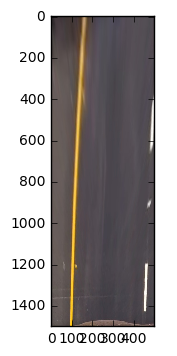

In [6]:
# NORMAL IMAGE
img = cv2.imread('vid_debug/edge_cases/36_warped_dst.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

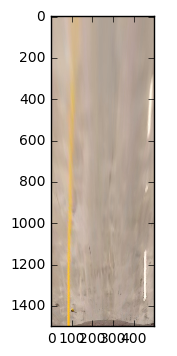

In [8]:
# LOW CONTRAST IMAGE
img = cv2.imread('vid_debug/edge_cases/86_warped_dst.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

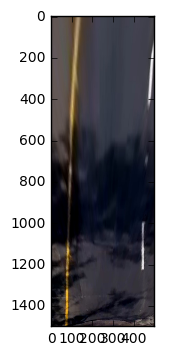

In [7]:
# SHADY IMAGE (has to be really dark to affect hls_s)
img = cv2.imread('vid_debug/edge_cases/117_warped_dst.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()